In [1]:
!pip install deep_tabular_augmentation

Defaulting to user installation because normal site-packages is not writeable
  Created wheel for deep-tabular-augmentation: filename=deep_tabular_augmentation-0.5.3-py3-none-any.whl size=7933 sha256=79bee2b9837829318c2c3dfd7994ded0c7e2c9c2655d24f02bfaa58a6cd31c7c
  Stored in directory: /home/user/.cache/pip/wheels/08/12/11/9565e20b3fe6fd8c76ad6fd5ddc3e044476709408066fec146
Successfully built deep-tabular-augmentation


In [2]:
import os
import numpy as np
import torch
from torch import nn
from torch import optim
from sklearn.preprocessing import StandardScaler
from functools import partial
import deep_tabular_augmentation as dta
from Data_Augmentation.vpower_src.utils.auxiliary_functions import *
import matplotlib.pyplot as plt

In [3]:
data_dir_s =  "../../Data/synthetic_data"
data_dir_r =  "../../Data/split_quad"
data_tag = "RD"

In [5]:
# Load data partitions and assign them to dictionary data_all

data_all = {}
#for partition in ["train", "test", "val", "lourd"]:
#    df = load_data_and_set_index(filepath=os.path.join(data_dir_s, f"{partition}.csv"), index_column_name="index")
#    data_all[partition+"_s"] = df
for partition in ["train", "test", "val", "lourd"]:
    df = load_data_and_set_index(filepath=os.path.join(data_dir_r, f"{partition}.csv"), index_column_name="index")
    data_all[partition+"_r"] = df

if data_tag=="RD":
    data_all["train"]=data_all["train_r"]
    data_all["test"]=data_all["test_r"]
else:
    data_all["train"]=   pd.concat([data_all["train_r"], data_all["train_s"]])
    data_all["test"] = pd.concat([data_all["test_r"], data_all["test_s"]])
    
data_flight1 = {}
data_flight1["train"] = data_all["train"].loc[data_all["train"]["flight"] == 1]
data_flight1["test"] = data_all["test"].loc[data_all["test"]["flight"] == 1]
data_flight1["train"]

,time_start,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,...,angular_z,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,speed,payload,altitude,route,power,power_smoothed
index,,,,,,,,,,,,,,,,,,,,,
112,2019-04-07 10:13:00,1,0.00,1.4,37.0,24.178350,0.389637,-79.782396,40.458047,270.407091,...,-0.000479,0.033248,-0.114812,-9.824341,4,0,25,R5,9.420778,9.420778
113,2019-04-07 10:13:00,1,0.21,1.4,36.0,23.517269,6.154673,-79.782396,40.458047,270.432353,...,0.011397,0.042173,-0.108319,-9.837841,4,0,25,R5,144.741104,144.741104
114,2019-04-07 10:13:00,1,0.31,1.4,42.0,24.109488,1.025779,-79.782396,40.458047,270.433609,...,0.017794,0.005411,-0.188141,-9.812851,4,0,25,R5,24.731003,24.731003
115,2019-04-07 10:13:00,1,0.50,1.4,42.0,24.189619,0.278312,-79.782396,40.458047,270.459037,...,-0.005043,0.034055,-0.114786,-9.808225,4,0,25,R5,6.732263,6.732263
116,2019-04-07 10:13:00,1,0.61,1.3,41.0,24.192123,0.389637,-79.782396,40.458047,270.460150,...,-0.012929,0.008335,-0.094107,-9.812603,4,0,25,R5,9.426145,9.426145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239,2019-04-07 10:13:00,1,169.10,1.7,92.0,22.500603,5.033473,-79.782354,40.458037,268.150388,...,0.022862,0.264301,0.581728,-9.760308,4,0,25,R5,113.256177,113.256177
1240,2019-04-07 10:13:00,1,169.20,1.7,90.0,22.493092,5.089135,-79.782354,40.458037,268.170896,...,-0.011390,0.207800,0.540354,-9.742634,4,0,25,R5,114.470383,114.470383
1241,2019-04-07 10:13:00,1,169.30,1.7,92.0,22.498098,5.025521,-79.782354,40.458037,268.153808,...,-0.000938,0.246509,0.592650,-9.784649,4,0,25,R5,113.064672,113.064672


In [7]:
input_features = [
#"time_start",
#"flight",
"time",
"wind_speed",
"wind_angle",
#"battery_voltage",
#"battery_current",
#"position_x",
#"position_y",
"position_z",
"angular_z",
"orientation_x",
"orientation_y",
"orientation_z",
"orientation_w",
"velocity_x",
"velocity_y",
"velocity_z",
"angular_x",
"angular_y",
"linear_acceleration_x",
"linear_acceleration_y",
"linear_acceleration_z",
#"speed",
"payload",
#"altitude",
#"route"
]

target = "power_smoothed"

In [8]:
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(data_all["train"][input_features])
X_test_scaled = x_scaler.fit_transform(data_all["test"][input_features])
datasets = dta.create_datasets_no_target_var(X_train_scaled, X_test_scaled)
data = dta.DataBunch(*dta.create_loaders(datasets, bs=1024))

In [ ]:
#datasets = dta.create_datasets_no_target_var(data_all["train"][input_features], data_all["test"][input_features])
#data = dta.DataBunch(*dta.create_loaders(datasets, bs=1024))

In [12]:
D_in = X_train_scaled.shape[1]
#VAE_arch = [50, 12, 12]
VAE_arch = [25,5,5]
df_cols = list(df.columns)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = dta.Autoencoder(D_in, VAE_arch, latent_dim=3).to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
loss_func = dta.customLoss()

/opt/conda/lib/python3.8/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [13]:
D_in

18

Learner class

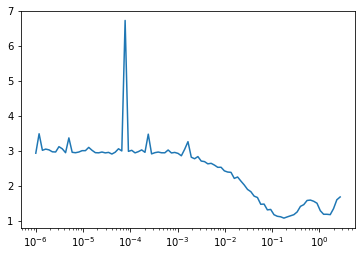

In [15]:
learn = dta.Learner(model, opt, loss_func, data, cols=df_cols)
run = dta.Runner(cb_funcs=[dta.LR_Find, dta.Recorder])
run.fit(10000, learn)
run.recorder.plot(skip_last=5)

Set up a Learning Rate schema and train the model: 

In [16]:
sched = dta.combine_scheds([0.3, 0.7], [dta.sched_cos(0.01, 0.1), dta.sched_cos(0.1, 0.01)])

In [17]:
cbfs = [partial(dta.LossTracker, show_every=25), dta.Recorder, partial(dta.ParamScheduler, 'lr', sched)]
model = dta.Autoencoder(D_in, VAE_arch, latent_dim=3).to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
learn = dta.Learner(model, opt, loss_func, data, cols=df_cols)
run = dta.Runner(cb_funcs=cbfs)
run.fit(100, learn)

epoch: 25
train loss is: 1.2704428434371948
validation loss is: 0.9980525970458984
epoch: 50
train loss is: 1.0114878416061401
validation loss is: 1.0016608238220215
epoch: 75
train loss is: 1.0069081783294678
validation loss is: 1.0019980669021606
epoch: 100
train loss is: 1.0050930976867676
validation loss is: 1.0019707679748535


In [18]:
store_path = "models/DA"
torch.save(model.state_dict(), os.path.join(store_path, "da_VAE_All.pth"))

FileNotFoundError: [Errno 2] No such file or directory: 'models/DA/da_VAE_All.pth'

Check created data:

In [19]:
new_data_points = 1000
df_fake = run.predict_df(learn, no_samples=new_data_points, scaler=x_scaler)
std_list = list(df[df_cols].std()/10)
df_fake_with_noise = run.predict_with_noise_df(learn, no_samples=new_data_points, mu=0, sigma=std_list, scaler=x_scaler)
df_fake_with_noise.head()

ValueError: Shape of passed values is (1000, 18), indices imply (1000, 29)

In [ ]:
# Plot - Real Data
df1=data_all["train"]

fig, ax = plt.subplots()
fig.set_size_inches(15.5, 8.5)
ax.scatter(df1['time'], df1['power_smoothed'], alpha=0.5)

ax.set_xlabel('time', fontsize=15)
ax.set_ylabel('power', fontsize=15)
ax.set_title('Real Data: time vs power', fontsize=15)

ax.grid(True)
fig.tight_layout()

plt.show()

In [ ]:
# Plot - Fake Data
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 8.5)
ax.scatter(df_fake_with_noise['time'], df_fake_with_noise['power_smoothed'], alpha=0.5)

ax.set_xlabel('time', fontsize=15)
ax.set_ylabel('power', fontsize=15)
ax.set_title('Fake Data: time vs power', fontsize=15)

ax.grid(True)
fig.tight_layout()

plt.show()

In [ ]:
# Plot - Fake Data
feature_under_study = "power_smoothed"

plt.figure(figsize=(6, 6))
plt.scatter(df_fake_with_noise["time"], df_fake_with_noise["power_smoothed"] / 1e3,
            c=df_fake_with_noise[feature_under_study],
            s=4, label="TRAIN")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("Power")
#plt.xlim(4, 25)
#plt.ylim(-2, 45)
plt.grid()

cbar = plt.colorbar()
cbar.set_label(feature_under_study, rotation=90)
plt.clim(-15, 50)

plt.show()
plt.close()